<a href="https://colab.research.google.com/github/zhuofachen/Emotion-detection/blob/master/Saliency_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision


class VggFeatures(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        # print(x.shape)

        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))

        return x


class Vgg(VggFeatures):
    def __init__(self, drop=0.2):
        super().__init__(drop)
        self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):
        x = super().forward(x)
        x = self.lin3(x)
        return x


In [5]:
# image = Image.open('<FILE_NAME_ON_JPG_OR_OTHERS>')

# # Set up the transformations
# transform_ = transforms.Compose([
# 		transforms.Resize(256),
# 		transforms.CenterCrop(224),
# 		transforms.Normalize(),
# 		transforms.ToTensor(),
# ])

# # Transforms the image
# image = transform_(image)

import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.fromarray(np.array(self.images[idx]))

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample





def load_data(path='fer2013.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping


def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label


def get_dataloaders(path='fer2013.csv', augment=False):
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation
        input: path to fer2013 csv file
        output: (Dataloader, Dataloader, Dataloader) """

    fer2013, emotion_mapping = load_data(path)

    xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
    xval, yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
    xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

    mu, st = 0, 255
    test_transform = transforms.Compose([
        transforms.CenterCrop(40),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mu,), std=(st,))
    ])
    


    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

            transforms.TenCrop(40),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),

            # transforms.ToTensor(),
            # transforms.Normalize(mean=(mu,), std=(st,))
        ])
    else:
        train_transform = test_transform

    train = CustomDataset(xtrain, ytrain, train_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=1, shuffle=True, num_workers=2)
    valloader = DataLoader(val, batch_size=1, shuffle=True, num_workers=2)
    testloader = DataLoader(test, batch_size=1, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader

trainloader, valloader, testloader = get_dataloaders()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This ty

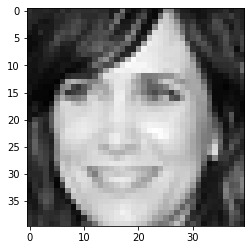

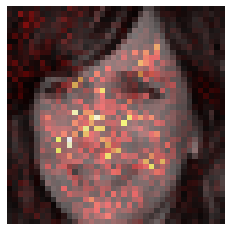

<Figure size 432x288 with 0 Axes>

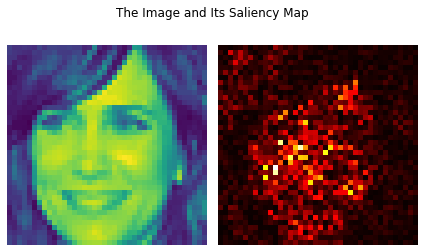

In [36]:
from matplotlib import pyplot as plt 
for img, label in trainloader:
  imgtmp = torch.squeeze(img)
  plt.imshow(imgtmp, cmap = 'gray')
  break

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('epoch_420')
net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])
net.eval()
img = img.to(device)
img.requires_grad_()
output = net(img)
output_idx = output.argmax()
output_max = output[0, output_idx]
output_max.backward()

saliency, _ = torch.max(img.grad.data.abs(), dim=1) 
saliency = saliency.reshape(40, 40)

plt.figure()
plt.imshow(imgtmp, cmap='gray')
plt.imshow(saliency.cpu(), cmap='hot', alpha=0.5)
plt.axis('off')

plt.show()
plt.figure()
# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(imgtmp)
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

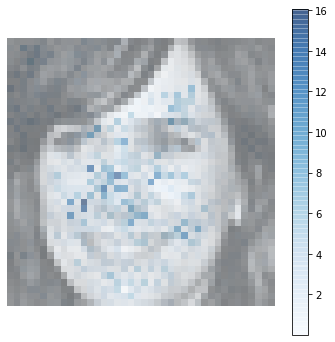

<Figure size 432x288 with 0 Axes>

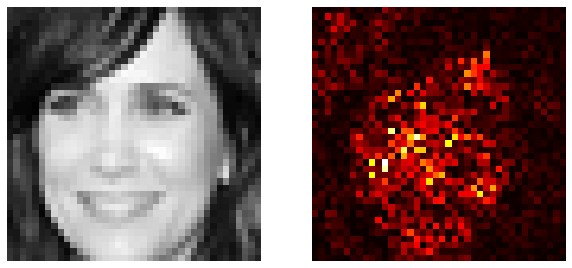

<Figure size 432x288 with 0 Axes>

In [54]:

saliency, _ = torch.max(img.grad.data.abs(), dim=1) 
# saliency = (saliency - min(saliency))/(max(saliency) - min(saliency))
saliency = saliency.reshape(40, 40) 


F1 = plt.figure(figsize = (6, 6))
plt.imshow(imgtmp, cmap='gray')
plt.imshow(saliency.cpu(), cmap='hot', alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()
plt.savefig('superimpose.png')

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(imgtmp, cmap = 'gray')
ax[0].axis('off')
im = ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
# plt.tight_layout()
# fig.suptitle('The Image and Its Saliency Map')
# fig.colorbar(im, ax = ax[1])
plt.show()
plt.savefig('original_saliency_map.png')

